In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
# Dataset root folder
dataset_root = Path(r"C:\Users\setup\OneDrive\Documents\School Work\PDAT 615\Diabetic Retinopathy")

# Check CSVs
print("Train CSV exists?", (dataset_root / "train" / "annotations.csv").exists())
print("Test CSV exists?", (dataset_root / "test" / "annotations.csv").exists())


Train CSV exists? True
Test CSV exists? True


In [3]:
# Train transforms (augmentation + normalization)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Test transforms (resize + normalization only)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [4]:
class RetinalDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.annotations.columns = [c.strip() for c in self.annotations.columns]  # clean column names
        self.img_dir = img_dir
        self.transform = transform

        # Debug print
        print("CSV Columns:", self.annotations.columns.tolist())
        print(self.annotations.head())

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = self.annotations.iloc[idx]["Image name"].strip()
        img_path = self.img_dir / img_name
        image = Image.open(img_path).convert("RGB")

        label = int(self.annotations.iloc[idx]["Retinopathy grade"])

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
train_ds = RetinalDataset(
    csv_file=dataset_root / "train" / "annotations.csv",
    img_dir=dataset_root / "train" / "images",
    transform=train_transform
)

test_ds = RetinalDataset(
    csv_file=dataset_root / "test" / "annotations.csv",
    img_dir=dataset_root / "test" / "images",
    transform=test_transform
)

print("Unique train labels:", train_ds.annotations["Retinopathy grade"].unique())
print("Train label counts:\n", train_ds.annotations["Retinopathy grade"].value_counts())


CSV Columns: ['Image name', 'Retinopathy grade', 'Risk of macular edema', 'Caption']
        Image name  Retinopathy grade  Risk of macular edema  \
0  IMAGE_01418.png                  2                      0   
1  IMAGE_01285.png                  0                      0   
2  IMAGE_02211.jpg                  0                      0   
3  IMAGE_00525.png                  1                      0   
4  IMAGE_01239.png                  1                      0   

                                             Caption  
0  CLINICAL SURVEY: Moderate diabetic retinopathy...  
1  CLINICAL FUNDUSCOPY: Comprehensive retinal eva...  
2  FUNDUS EVALUATION: Normal ophthalmoscopic exam...  
3  FUNDUS ASSESSMENT: Early diabetic retinopathy ...  
4  FUNDUS ASSESSMENT: Early diabetic retinopathy ...  
CSV Columns: ['Image name', 'Retinopathy grade', 'Risk of macular edema', 'Caption']
        Image name  Retinopathy grade  Risk of macular edema  \
0  IMAGE_01367.png                  1              

In [8]:
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=0)


In [9]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, padding=padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

class CustomCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.features = nn.Sequential(
            DepthwiseSeparableConv(3, 32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            DepthwiseSeparableConv(32, 64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            DepthwiseSeparableConv(64, 128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomCNN(num_classes=5).to(device)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


In [11]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_pred, all_true = [], []
    
    for i, (imgs, labels) in enumerate(loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        all_pred.append(preds)
        all_true.append(labels.detach().cpu().numpy())
        
        if i % 20 == 0:
            print(f"Batch {i}/{len(loader)} - Loss: {loss.item():.4f}")
    
    all_pred, all_true = np.concatenate(all_pred), np.concatenate(all_true)
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_true, all_pred)
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_pred, all_true = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1).detach().cpu().numpy()
            all_pred.append(preds)
            all_true.append(labels.detach().cpu().numpy())
    
    all_pred, all_true = np.concatenate(all_pred), np.concatenate(all_true)
    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = accuracy_score(all_true, all_pred)
    return epoch_loss, epoch_acc, all_true, all_pred


In [12]:
num_epochs = 10
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(num_epochs):
    print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion, device)

    scheduler.step(val_acc)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1} Summary - "
          f"Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")



=== Epoch 1/10 ===
Batch 0/99 - Loss: 1.6544
Batch 20/99 - Loss: 1.3707
Batch 40/99 - Loss: 1.3190
Batch 60/99 - Loss: 1.5068
Batch 80/99 - Loss: 1.3170
Epoch 1 Summary - Train loss: 1.3261, Train acc: 0.5041 | Val loss: 1.2714, Val acc: 0.5266

=== Epoch 2/10 ===
Batch 0/99 - Loss: 1.3186
Batch 20/99 - Loss: 1.3000
Batch 40/99 - Loss: 1.1461
Batch 60/99 - Loss: 1.2309
Batch 80/99 - Loss: 1.5411
Epoch 2 Summary - Train loss: 1.2676, Train acc: 0.5257 | Val loss: 1.2499, Val acc: 0.5266

=== Epoch 3/10 ===
Batch 0/99 - Loss: 1.0371
Batch 20/99 - Loss: 1.0800
Batch 40/99 - Loss: 1.4662
Batch 60/99 - Loss: 1.4534
Batch 80/99 - Loss: 1.1621
Epoch 3 Summary - Train loss: 1.2402, Train acc: 0.5257 | Val loss: 1.2127, Val acc: 0.5296

=== Epoch 4/10 ===
Batch 0/99 - Loss: 1.0102
Batch 20/99 - Loss: 1.3628
Batch 40/99 - Loss: 1.0242
Batch 60/99 - Loss: 1.6798
Batch 80/99 - Loss: 1.3250
Epoch 4 Summary - Train loss: 1.2266, Train acc: 0.5206 | Val loss: 1.2025, Val acc: 0.5562

=== Epoch 5/10 


Final Test Accuracy: 0.5621
Test Loss: 1.1767

Confusion Matrix:
 [[166   0  12   0   0]
 [ 43   0   1   0   0]
 [ 52   0  24   0   0]
 [ 14   0  11   0   0]
 [  7   0   8   0   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.93      0.72       178
           1       0.00      0.00      0.00        44
           2       0.43      0.32      0.36        76
           3       0.00      0.00      0.00        25
           4       0.00      0.00      0.00        15

    accuracy                           0.56       338
   macro avg       0.20      0.25      0.22       338
weighted avg       0.41      0.56      0.46       338



C:\Users\setup\anaconda3\envs\cv_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\setup\anaconda3\envs\cv_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\setup\anaconda3\envs\cv_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

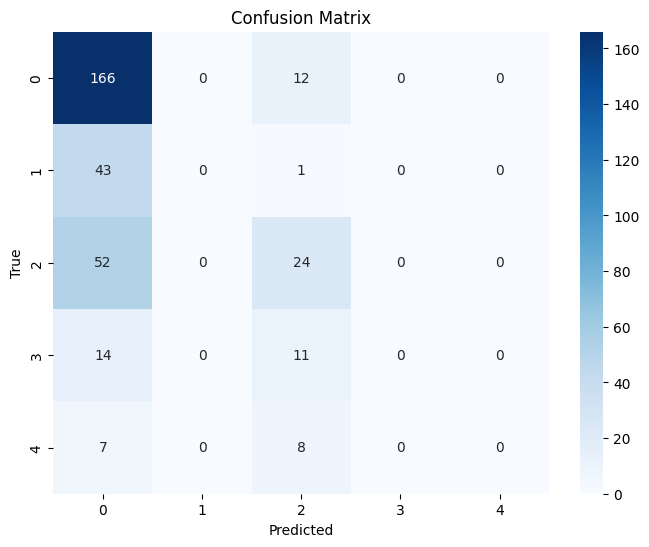

In [13]:
# ---- Evaluate on test set ----
val_loss, val_acc, y_true, y_pred = evaluate(model, test_loader, criterion, device)

print(f"\nFinal Test Accuracy: {val_acc:.4f}")
print(f"Test Loss: {val_loss:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

# Detailed classification report
report = classification_report(y_true, y_pred)
print("\nClassification Report:\n", report)

#Plot confusion matrix
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


# Observations

- Overall Performance: The model achieved a final test accuracy of 56.2% with a test loss of 1.18. This indicates that while the model correctly classifies a majority of the “grade 0” images, it struggles with higher grades of retinopathy.

- Class Imbalance: The confusion matrix and classification report show that the model performs well on the most common class (0: no disease) but fails to reliably classify rarer classes (1–4). This is reflected in very low precision, recall, and F1-scores for these classes.

Strengths:

    - The model is lightweight due to the use of depthwise separable convolutions, which reduces the number of parameters and speeds up computation.

    - Data augmentation and normalization likely helped the model generalize to unseen images in the test set.

Limitations:

    - Significant class imbalance in the dataset limits performance on less frequent classes.

    - The simple architecture may not have sufficient capacity to capture subtle differences in disease severity.

    - Training on CPU limits the ability to experiment with larger models or more extensive hyperparameter tuning.

# Reflection on Model Uniqueness

This model uses depthwise separable convolutions, which separate spatial feature extraction from channel-wise processing. Unlike traditional CNN layers that convolve across all input channels simultaneously, depthwise separable convolutions first apply a convolution per input channel and then combine channels with a pointwise convolution. This approach reduces the number of parameters and computation while retaining the ability to extract meaningful features.

The design differs from classical CNNs and standard architectures such as ResNet or MobileNet by incorporating a simpler, lightweight custom network tailored for the retinal dataset. Despite moderate accuracy, this architecture demonstrates potential for deployment in resource-constrained environments, such as mobile or edge devices for automated diabetic retinopathy screening. Future improvements could include techniques to handle class imbalance, such as weighted loss functions or oversampling, and experimenting with additional novel building blocks to increase feature representation.